In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import contextily as ctx
from shapely.wkt import load

import clean_utils
from importlib import reload


### Load Data

In [2]:
bluesky = pd.read_csv('../data/Blue Sky Code and Inputs/SF_Logistic_Data.csv')

In [3]:
allParcels = gpd.read_feather('../data/allParcels.geofeather')

In [4]:
sites = gpd.read_file('../data/site_inventory/xn--Bay_Area_Housing_Opportunity_Sites_Inventory__20072023_-it38a.shp')

In [5]:
tax = gpd.read_feather('../data/tax.geofeather')

In [6]:
slopes = gpd.read_file('../data/Slopes of 20% Or Greater/geo_export_2dd8ac56-99a0-4a45-ba46-c85a7407e3e5.shp')

In [7]:
census = gpd.read_file('../data/Census 2000_ Tracts for San Francisco (no water)'
                       '/geo_export_4609700a-c230-4617-92b7-4ef34f23f741.shp')

In [8]:
sfneighborhoods = gpd.read_file('../data/SF Find Neighborhoods/geo_export_2ecdf278-8615-4538-9268-0d4992d30e52.shp')

In [9]:
home_prices = pd.read_csv('../data/efz/Neighborhood_zhvi_uc_sfrcondo_tier_0.33_0.67_sm_sa_month.csv')
home_prices = home_prices[home_prices.City == 'San Francisco']
home_prices = home_prices[['RegionName', '2010-12-31']]
home_prices = home_prices[home_prices.notna().all(axis=1)]

### Geospatial version of bluesky data

In [10]:
start_year = 2011
parcels = bluesky[bluesky.year >= start_year]
trainY = parcels.groupby('MapBlkLot_Master')['Developed'].agg(lambda x: x.ne(0).any())
trainX = parcels[parcels.year == start_year]
trainDf = pd.merge(trainX.drop('Developed', axis=1), trainY, left_on='MapBlkLot_Master', right_index=True)

In [11]:
allParcels = allParcels[~(pd.to_datetime(allParcels.date_map_d).dt.year < trainDf.year.min())]
allParcels = allParcels[~(pd.to_datetime(allParcels.date_rec_d).dt.year < trainDf.year.min())]
allParcels = allParcels[~(pd.to_datetime(allParcels.date_rec_a).dt.year >= trainDf.year.max())]
allParcels = allParcels[~(pd.to_datetime(allParcels.date_map_a).dt.year >= trainDf.year.max())]

allParcels.date_map_a = pd.to_datetime(allParcels.date_map_a)
allParcels.date_rec_a = pd.to_datetime(allParcels.date_rec_a)
allParcels['year'] = allParcels.date_map_a.dt.year
allParcels = allParcels[allParcels.date_map_a.dt.year.notna()]
allParcels = allParcels.sort_values('year')

In [12]:
trainDf['year'] = trainDf['year'].astype(float)

In [13]:
df = pd.merge_asof(trainDf, allParcels[['geometry', 'year', 'mapblklot']], 
                   left_by='MapBlkLot_Master', right_by='mapblklot', on='year')

In [14]:
df = df.drop(columns=['mapblklot', 'year'])

In [157]:
df.Developed.mean()

0.0017173827869922946

In [16]:
df = gpd.GeoDataFrame(df, crs=allParcels.crs)

### extend df to have permits up till 2019

In [17]:
homes = pd.read_excel('../data/Housing Production 2005-2022.xlsx')
dbi = gpd.read_feather('../data/dbi_permits.geofeather')

date_cols = [c for c in dbi.columns if 'date' in c]
dbi[date_cols] = dbi[date_cols].apply(lambda x: pd.to_datetime(x, errors='coerce'))
cost_cols = [c for c in dbi.columns if 'cost' in c]
dbi[cost_cols] = dbi[cost_cols].apply(lambda x: pd.to_numeric(x, errors='coerce'))
unit_cols = [c for c in dbi.columns if 'unit' in c]
dbi[unit_cols] = dbi[unit_cols].apply(lambda x: pd.to_numeric(x, errors='coerce'))

In [18]:
homes = homes[homes.Net_Units_Completed >= 1]

In [19]:
homes = homes.sort_values('Date_Completed')

In [20]:
homes = homes.drop_duplicates('BlockLot')

In [21]:
homes = homes[(homes.Completion_Year >= 2011) & (homes.Completion_Year <= 2019)]

In [22]:
dbi.columns

Index(['record_id', 'proposed_construction_type_description', 'issued_date',
       'existing_construction_type_description', 'zipcode',
       'neighborhoods_analysis_boundaries', 'fire_only_permit', 'proposed_use',
       'existing_use', 'description', 'tidf_compliance', 'revised_cost',
       'existing_construction_type', 'site_permit', 'plansets',
       'permit_creation_date', 'status_date',
       'first_construction_document_date', 'existing_units', 'filed_date',
       'street_name', 'block', 'estimated_cost', 'permit_expiration_date',
       'unit_suffix', 'proposed_construction_type', 'permit_type_definition',
       'status', 'completed_date', 'permit_number', 'street_number_suffix',
       'lot', 'number_of_existing_stories', 'street_suffix', 'proposed_units',
       'unit', 'permit_type', 'number_of_proposed_stories',
       'voluntary_soft_story_retrofit', 'supervisor_district', 'street_number',
       'structural_notification', 'geometry'],
      dtype='object')

In [23]:
dbi = dbi[((dbi.permit_creation_date.dt.year >= 2011) & (dbi.permit_creation_date.dt.year <= 2019))]

In [24]:
dbi = dbi.sort_values('permit_creation_date', ascending=False)
dbi = dbi.drop_duplicates('permit_number')

# NB: 5 rows in homes don't match-
permits = pd.merge(dbi[['geometry', 'permit_number', 'permit_creation_date']],
                   homes,
                   left_on='permit_number', right_on='BPA', how='inner')
permits = permits[['geometry', 'permit_number', 'Permit Issued Date',
                   'permit_creation_date', 'Net_Units_Completed', 
                   'Date_Completed', 'BlockLot']]

In [25]:
permits.Net_Units_Completed

0       1.0
1       2.0
2       1.0
3       3.0
4       1.0
       ... 
1383    1.0
1384    1.0
1385    1.0
1386    1.0
1387    1.0
Name: Net_Units_Completed, Length: 1388, dtype: float64

In [26]:
df_8yr = gpd.sjoin(df, permits.to_crs(df.crs), how='left', predicate='contains')

In [27]:
df_8yr = df_8yr.drop_duplicates('MapBlkLot_Master')

In [28]:
np.logical_or(df_8yr.index_right.notna(), df_8yr.Developed).sum()

1347

In [29]:
df_8yr.Developed = df_8yr.index_right.notna()

In [158]:
df_8yr.Developed.mean()

0.007672717774585347

#### Get dbi permits from past cycle

In [30]:
pipeline = clean_utils.get_pipeline_permits(end_year=2011)

In [31]:
permit_type_map = {1: 'new construction',
                   2: 'new construction wood frame',
                   3: 'additions alterations or repairs',
                   4: 'sign',
                   5: 'grade or quarry or fill or excavate',
                   6: 'demolitions',
                   7: 'wall or painted sign',
                   8: 'otc alterations'}

permit_type_map = {k: '_'.join(v.split(' ')) for k, v in permit_type_map.items()}
permit_type_map = {str(k): v for k, v in permit_type_map.items()}
permit_type_map = {k: 'permit_' + v for k, v in permit_type_map.items()}
permit_type_map

{'1': 'permit_new_construction',
 '2': 'permit_new_construction_wood_frame',
 '3': 'permit_additions_alterations_or_repairs',
 '4': 'permit_sign',
 '5': 'permit_grade_or_quarry_or_fill_or_excavate',
 '6': 'permit_demolitions',
 '7': 'permit_wall_or_painted_sign',
 '8': 'permit_otc_alterations'}

### Merge into bluesky data

In [32]:
def merge_pipeline(df, pipeline):
    df = pd.merge(df, pipeline, left_on='MapBlkLot_Master', right_index=True, how='left')
    df[pipeline.columns] = df[pipeline.columns].fillna(0)
    return df

In [33]:
df_8yr = merge_pipeline(df_8yr, pipeline)

In [34]:
pipeline_columns = [c for c in df_8yr.columns if c.startswith('permit')]

In [35]:
df_8yr = df_8yr.rename(dict(zip(pipeline_columns, 
                                [permit_type_map.get(c[-1], c) for c in pipeline_columns])),
                       axis=1)

### Merge Tax Data

In [36]:
reload(clean_utils)

<module 'clean_utils' from 'C:\\Users\\sadamerdji\\Documents\\GitHub\\dissertation\\pdev\\clean_utils.py'>

In [37]:
full_df = clean_utils.merge_tax(df_8yr, tax, year=2011, parcels=allParcels)

In [38]:
full_df = full_df.drop('index_right', axis=1)

In [39]:
full_df.shape

(151299, 71)

## Feature Engineering

### Slopes, Census Tracts, Rents

<Figure size 432x288 with 0 Axes>

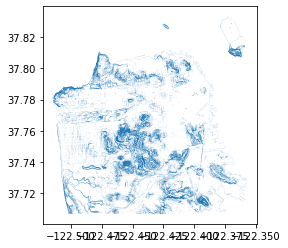

In [40]:
plt.clf()
slopes.plot()
plt.show()

In [41]:
entirely_steep = gpd.sjoin(full_df[['MapBlkLot_Master', 'geometry']], 
                           slopes[['geometry']], how="left", predicate='within')

In [42]:
partly_steep = gpd.sjoin(full_df[['MapBlkLot_Master', 'geometry']],
                         slopes[['geometry']], how="left", predicate='contains')

In [43]:
partly_steep = partly_steep.drop_duplicates('MapBlkLot_Master')

In [44]:
partly_steep.shape

(151299, 3)

In [45]:
full_df['entirely_steep_lot'] = entirely_steep.index_right.notna()

In [46]:
full_df['partly_steep_lot'] = partly_steep.index_right.notna()

<Figure size 432x288 with 0 Axes>

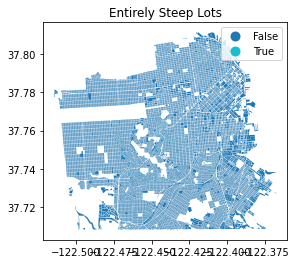

In [47]:
plt.clf()
full_df.plot(column='entirely_steep_lot', legend=True)
plt.title('Entirely Steep Lots')
plt.show()

<Figure size 432x288 with 0 Axes>

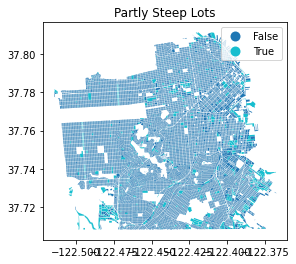

In [48]:
plt.clf()
full_df.plot(column='partly_steep_lot', legend=True)
plt.title('Partly Steep Lots')
plt.show()

In [49]:
full_df = full_df.reset_index(drop=True)

### Census Tracts

variable names explained here :
https://www.rand.org/content/dam/rand/www/external/labor/projects/dnors/pubs/pdfs/DNORS_contextual_block_listing.pdf

To make comparisons of racial demographics, age demographics, and family compositions comparable across tracts of different population densities, I divide each by the population of the tract in 2000.

In [50]:
# Drop columns that are all constant or whose inclusion creates perfect multicollinearity 
census = census.drop(['tractid', 'trt2000', 'state', 'objectid', 
                      'rural', 'urban', 'county', 'fipsstco', 
                      'owner_occ', 'other', 'males', 'age_under5',
                      'stfid'],
                     axis=1)

In [51]:
pop_variables = ['age_18_21', 'age_22_29', 'age_30_39', 'age_40_49', 'age_50_64',
                 'age_5_17', 'age_65_up', 
                 'ameri_es', 'asian', 'black', 'white',  'hawn_pi', 'mult_race', # races
                 'hispanic', # Hispanic is not a race
                 'renter_occ',
                 'females', 'hsehld_1_f', 'hsehld_1_m',
                 'families', 'marhh_no_c', 'marhh_chd', 'mhh_child', 'fhh_child']
census.loc[:, pop_variables] = census[pop_variables].apply(lambda x: x / census['pop2000'])

In [52]:
census.vacant = census.vacant / census.hse_units

In [53]:
census = census.add_prefix('census_')

In [54]:
census = census.rename({'census_geometry': 'geometry',
                        'census_ameri_es': 'census_native'}, axis=1)

In [55]:
full_df_census = gpd.sjoin_nearest(full_df.to_crs('EPSG:26910'),
                                    census.to_crs('EPSG:26910'),
                                    how='left')

In [56]:
full_df_census.shape

(151523, 107)

In [57]:
full_df_census = full_df_census.drop_duplicates(subset=['MapBlkLot_Master', 'block', 'lot', 'geometry'])

In [58]:
full_df_census.shape

(151299, 107)

In [59]:
full_df_census = full_df_census.drop(['index_right'], axis=1)

In [60]:
full_df = full_df_census

In [61]:
full_df = full_df.reset_index(drop=True)

### Home Prices

#### Make Zillow data geospatial for a geospatial join

In [95]:
neigh = gpd.read_file('../../../../Downloads/ZillowNeighborhoods-CA/ZillowNeighborhoods-CA.shp')

In [96]:
sf = neigh[neigh.CITY.str.contains('San Francisco')]

In [97]:
sf_neighborhoods = sf[['NAME', 'geometry']]

In [98]:
sf_neighborhoods = sf_neighborhoods.to_crs(full_df.crs)

In [99]:
sf_neighborhoods = sf_neighborhoods.rename(columns={'NAME': 'zillow_neighborhood_name'})

In [127]:
sf_neighborhoods = sf_neighborhoods.replace({'zillow_neighborhood_name': {
    'Marina' : 'Marina District',
    'Haight-Ashbury': 'Haight',
    'South Of Market': 'South of Market',
    'Ocean View': 'Oceanview',
    'Castro-Upper Market': 'Castro',
    'Twin Peaks': 'Clarendon Heights',
    'West Of Twin Peaks': 'Forest Knolls'
}})

In [128]:
sf_neighborhoods.sort_values('zillow_neighborhood_name')

,zillow_neighborhood_name,geometry
789,Bayview,"POLYGON ((554574.611 4178337.626, 554360.689 4..."
790,Bernal Heights,"POLYGON ((552517.066 4178186.827, 552388.135 4..."
791,Castro,"POLYGON ((550550.406 4180426.980, 550611.963 4..."
792,Chinatown,"POLYGON ((551924.981 4183510.041, 552256.809 4..."
819,Clarendon Heights,"POLYGON ((549269.560 4178891.122, 549038.810 4..."
793,Crocker Amazon,"POLYGON ((548119.335 4173580.951, 548827.215 4..."
794,Diamond Heights,"POLYGON ((548335.437 4177695.536, 548409.458 4..."
795,Downtown,"POLYGON ((552329.844 4182220.745, 550942.672 4..."
796,Excelsior,"POLYGON ((552739.611 4175370.286, 551595.153 4..."
797,Financial District,"POLYGON ((553314.526 4183712.225, 553193.987 4..."


In [129]:
full_df_zill = full_df.sjoin_nearest(sf_neighborhoods, how='left')

In [130]:
full_df_zill = pd.merge(full_df_zill,
                        home_prices,
                        left_on='zillow_neighborhood_name', 
                        right_on='RegionName', 
                        how='left')

In [131]:
full_df_zill = full_df_zill.rename(columns={'2010-12-31': 'rent2010'})

In [132]:
full_df_zill.rent2010.isna().mean()

0.0008079912945454071

In [136]:
full_df = full_df_zill.drop(columns=['RegionName', 'index_right'])

In [137]:
full_df = full_df.drop_duplicates(subset=['MapBlkLot_Master', 'block', 'lot', 'geometry'])


In [139]:
full_df = full_df.reset_index(drop=True)

<Figure size 432x288 with 0 Axes>

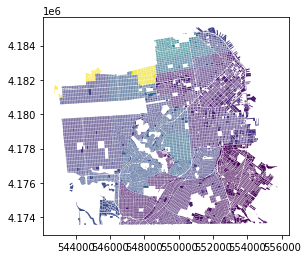

In [140]:
plt.clf()
full_df.plot(column='rent2010')
plt.show()

### Treat inclusion in site inventory as a feature

In [141]:
full_df = clean_utils.get_site_inventory_feature(full_df, sites, cycle=4)
#full_df5 = clean_utils.get_site_inventory_feature(full_df5, sites, cycle=4)

### Simplify names of tax variables

### Convert geometry to x, y coordinates

In [142]:
# Get center point of parcel and store x, y as features
full_df['x_coord'] = full_df.geometry.representative_point().x
full_df['y_coord'] = full_df.geometry.representative_point().y

### Drop constant columns

In [ ]:
#full_df4 = full_df4.drop([c for c in full_df4.columns if 'CANTID' in c], axis=1)
#full_df5 = full_df5.drop([c for c in full_df5.columns if 'CANTID' in c], axis=1)

In [143]:
full_df = full_df.drop(full_df.columns[full_df.nunique() <= 1], axis=1)

In [150]:
full_df = full_df.drop(['block', 'lot', 'property_location'], axis=1)

In [151]:
full_df = full_df.rename({'Envelope_1000': 'buildable_envelope_1000'}, axis=1)

In [155]:
full_df.Developed.mean()

0.0073298567736733225

In [152]:
full_df['existing_envelope_1000'] = ( 1 / full_df['Upzone_Ratio']) * full_df['buildable_envelope_1000']

In [153]:
full_df.to_csv('cleaned_2011_data.csv', index=False)
#full_df5.to_csv('cleaned_rhna5_data.csv', index=False)

In [165]:
full_df.loc[full_df['Permit Issued Date'].dt.year > 2014, 'Developed'] = 0

381       True
711       True
873       True
880       True
1232      True
          ... 
150907    True
150913    True
151124    True
151245    True
151297    True
Name: Developed, Length: 871, dtype: bool